# Notebook 0 - Exploring Data

## Section 0 - Import libraries and basic metadata

In [1]:
import os

import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import wfdb

from bc.beats import get_beats
from bc.io import ann_to_df

%matplotlib qt

In [2]:
base_dir = os.path.abspath('..')
data_dir = os.path.join(base_dir, 'data')

# Table of record names and the beat types they contain
beat_table = pd.read_csv(os.path.join(data_dir, 'beat-types.csv'), dtype={'record':object})
beat_table.set_index('record', inplace=True)
# List of all records in the database
all_records = beat_table.index.values

In [3]:
# Records with L: Left bundle branch block beat
l_records = beat_table.loc[beat_table['L']>0].index.values

,label_store,symbol,description,n_occurrences
2,2,L,Left bundle branch block beat,38
5,5,V,Premature ventricular contraction,1


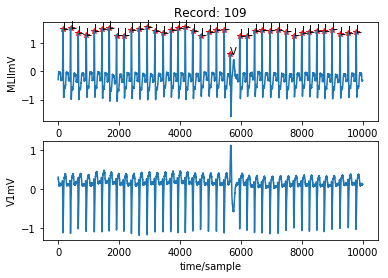

,label_store,symbol,description,n_occurrences
2,2,L,Left bundle branch block beat,31


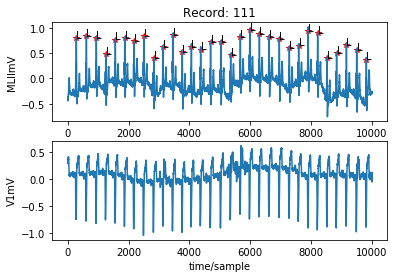

,label_store,symbol,description,n_occurrences
2,2,L,Left bundle branch block beat,12
3,3,R,Right bundle branch block beat,8
28,28,+,Rhythm change,4
5,5,V,Premature ventricular contraction,13


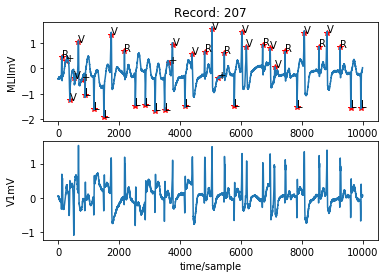

,label_store,symbol,description,n_occurrences
2,2,L,Left bundle branch block beat,31
28,28,+,Rhythm change,2
5,5,V,Premature ventricular contraction,5
14,14,~,Signal quality change,4


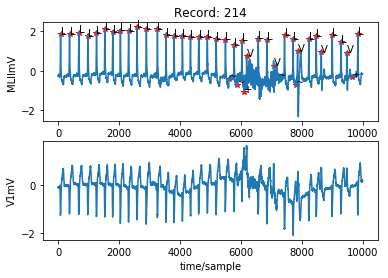

In [18]:
# Visualize some records
for rec_name in l_records:
    # Load the signals and L beat annotations
    rec = wfdb.rdrecord(os.path.join(data_dir, rec_name), sampfrom=22000, sampto=32000)
    ann = wfdb.rdann(os.path.join(data_dir, rec_name), extension='atr',
                     sampfrom=22000, sampto=32000, shift_samps=True, summarize_labels=True)
    # Show the annotations contained in the files
    display(ann.contained_labels)
    # Get the peak samples and symbols in a dataframe. Keep only L beats.
    qrs_df = ann_to_df(ann, rm_sym=['+'])
    wfdb.plot_wfdb(record=rec, annotation=ann, plot_sym=True)     

In [19]:
# Load the entire records
for rec_name in l_records:
    # Load the signals and L beat annotations
    sig, fields = wfdb.rdsamp(os.path.join(data_dir, rec_name))
    ann = wfdb.rdann(os.path.join(data_dir, rec_name), extension='atr')
    # Get the peak samples and symbols in a dataframe. Remove the non-beat annotations
    qrs_df = ann_to_df(ann, rm_sym=['+', '~'])

len_left: 86 len_right: 219


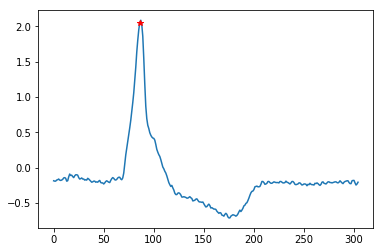

len_left: 94 len_right: 220


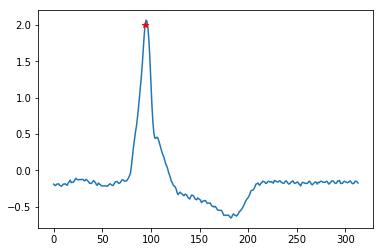

len_left: 94 len_right: 220


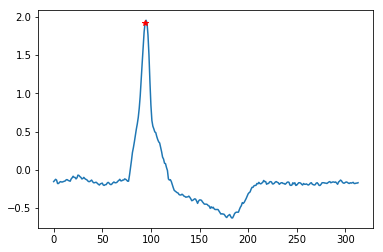

len_left: 94 len_right: 221


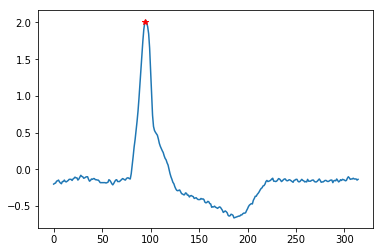

len_left: 95 len_right: 208


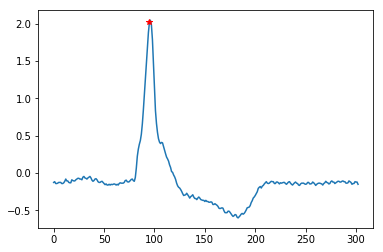

len_left: 89 len_right: 161


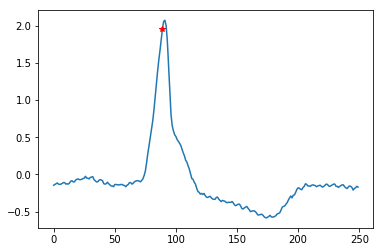

len_left: 103 len_right: 194


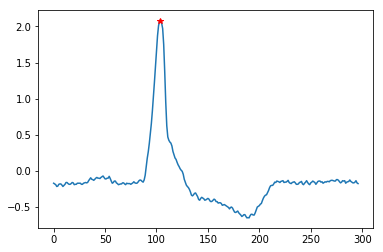

len_left: 83 len_right: 194


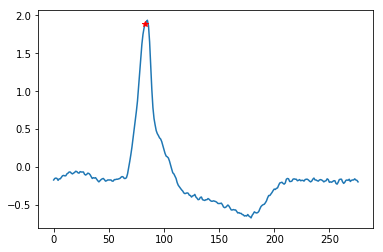

In [25]:
# Load a record, extract some beats, and view them.
sig, fields = wfdb.rdsamp(os.path.join(data_dir, rec_name), sampto=3000)
ann = wfdb.rdann(os.path.join(data_dir, rec_name), extension='atr', sampto=3000)
# Get the peak samples and symbols in a dataframe. Remove the non-beat annotations
qrs_df = ann_to_df(ann, rm_sym=['+', '~'])
beats, centers = get_beats(sig=sig[:, 0], qrs_inds=qrs_df['sample'].values, 
                           beat_types = qrs_df['symbol'].values, wanted_type='L',
                           view=True)

In [28]:
# Extract all available L beats
l_beats, l_centers = [], []
for rec_name in l_records:
    # Load the signals and L beat annotations
    sig, fields = wfdb.rdsamp(os.path.join(data_dir, rec_name))
    ann = wfdb.rdann(os.path.join(data_dir, rec_name), extension='atr')
    # Get the peak samples and symbols in a dataframe. Remove the non-beat annotations
    qrs_df = ann_to_df(ann, rm_sym=['+', '~'])
    beats, centers = get_beats(sig=sig[:, 0], qrs_inds=qrs_df['sample'].values, 
                           beat_types = qrs_df['symbol'].values, wanted_type='L')
    l_beats += beats
    l_centers += centers

In [ ]:
base_dir = os.path.abspath('..')
data_dir = os.path.join(base_dir, 'data')

# Table of record names and the ground truth labels of their alarms
beat_table = pd.read_csv(os.path.join(data_dir, 'beat-types.csv'))

# Set the name as the index for the alarm data table
alarms.set_index('recordname', inplace=True)
# List of record names
record_names = list(alarms.index)
# Record names with true alarms
record_names_true = list(alarms.loc[alarms['result']==True].index)
# Record names with false alarms
record_names_false = list(alarms.loc[alarms['result']==False].index)
    
# Distribution of alarm results
n_true = len(record_names_true)
n_false = len(record_names_false)

print('Alarm distribution: %d True, %d False, %d Total' % (n_true, n_false, len(alarms)))
display(alarms[:15])

## Section 1 - Inspect signal content

In [ ]:
# All channels can be categorized into ecg, blood pressure, or respiration.
# We are not using RESP in this project.
ecg_channels = []
bp_channels = []

for record_name in record_names:
    record = wfdb.rdheader(os.path.join(data_dir, record_name))
    # First 2 channels are ECGs
    ecg_channels.append(record.sig_name[0])
    ecg_channels.append(record.sig_name[1])
    
    # Channel 2 is blood pressure. Channel 3 is either blood pressure or resp.
    for ch in range(2, record.n_sig):
        if record.sig_name[ch] != 'RESP':
            bp_channels.append(record.sig_name[ch])

all_channels = ecg_channels + bp_channels
channel_frequencies = dict(zip(all_channels,
                               [all_channels.count(chan) for chan in all_channels]))

ecg_channels = list(set(ecg_channels))
bp_channels = list(set(bp_channels))


print('ECG channels:', ecg_channels)
print('Blood pressure channels:', bp_channels)
display('Channel frequencies: ', channel_frequencies)

*In this session, we are only going to use channels 0-2*

## Section 2 - Visualize Signals

In [ ]:
from wfdb import processing

In [ ]:
# All alarms are triggered within last 10s. Visualize 4:40 to 5:00 - 280 to 300s.
def visualize_raw(record_name, start_sec=290, stop_sec=300):
    
    fs = 250
    # Read record
    signal, fields = wfdb.rdsamp(os.path.join(data_dir, record_name),
                                 sampfrom=start_sec * fs,
                                 sampto=stop_sec * fs, channels=[0,1,2])

    # Get beat indices
    qrs_0 = processing.gqrs_detect(signal[:, 0], fs=fs)
    qrs_1 = processing.gqrs_detect(signal[:, 1], fs=fs)
    pulse_2 = wfdb.rdann(os.path.join(data_dir, record_name), 'wabp2',
                         sampfrom = start_sec * fs,
                         sampto=stop_sec * fs, shift_samps=True).sample

    beat_inds = [qrs_0, qrs_1, pulse_2]

    # Alarm result
    result = alarms.loc[record_name, 'result']

    if result:
        result = 'True Alarm'
        style='r'
    else:
        result = 'False Alarm'
        style='b'

    wfdb.plot_items(signal=signal, ann_samp=beat_inds, time_units='seconds', fs=fs,
                    title='Record: %s %s' % (record_name, result), figsize = (16, 8),
                    ylabel=fields['sig_name'], sig_style=style, ann_style=['k*'])


In [ ]:
for record_name in record_names[260:275]:
    visualize_raw(record_name, start_sec=280, stop_sec=300)

## Section 3 - Calculate and Visualize Basic Signal Features

### Features to extract for each signal

- Statistical moments
- Detected beats and derived information
  - Number of beats detected
  - heart rate
- Spectral content
  - Relative power ratios of low, medium, high frequencies

In [ ]:
from scipy.signal import periodogram
from scipy.stats import skew, kurtosis

In [ ]:
# Functions for calculating features
def calc_moments(data):
    """
    Calculate moments of a 1d feature: mean, std, skew, kurtosis
    """
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    data_skew = skew(data)
    data_kurt = kurtosis(data)
    
    return data_mean, data_std, data_skew, data_kurt

def calc_spectral_ratios(signal, fs, f_low=5, f_med=25, f_high=70):
    """
    Return the power ratio contained in 3 bands.
    LF (0–5 Hz), MF (5–25 Hz) and HF (30–70 Hz).
    """
    # Calculate power spectrum using periodogram
    f, pxx = periodogram(signal, fs)
    
    # Relative areas
    a1 = np.sum(pxx[np.where(f > -1)[0][0]:np.where(f > f_low)[0][0]])
    a2 = np.sum(pxx[np.where(f > 5)[0][0]:np.where(f > f_med)[0][0]])
    a3 = np.sum(pxx[np.where(f > 25)[0][0]:np.where(f > f_high)[0][0]])
    a_total = a1 + a2 + a3
    
    # If there is no spectral power. ie. signal is flatline.
    if a_total == 0:
        return 1, 0 ,0
    
    return a1 / a_total, a2 / a_total, a3 / a_total


In [ ]:
def calc_features(record_name):
    """
    Aggregate function. Calculate all features for the last 10s of a record.
    
    Features for each signal are:
    - Moments: mean, std, skew, kurtosis
    - Number of beats detected
    - Average heart rate
    - Spectral band power ratios
    
    Parameters
    ---------
    record_name : str
        The record name
    
    Returns
    -------
    features : pandas dataframe
        Dataframe of the calculated features

    """
    fs = 250
    start_sec = 290
    stop_sec = 300
    
    # Desired features
    features = []
    # Features are calculated for each individual signal
    feature_labels = [['_'.join([moment, str(ch)]) for moment in ['mean', 'std', 'skew',
                                                                  'kurt', 'n_beats', 'hr',
                                                                  'lfp', 'mfp', 'hfp']] for ch in range(3)]
    feature_labels = [x for y in feature_labels for x in y] + ['result']
    
    # Read record
    signal, fields = wfdb.rdsamp(os.path.join(data_dir, record_name),
                                 sampfrom=start_sec*fs, sampto=stop_sec*fs,
                                 channels=[0, 1, 2])
    
    # Get beat locations
    qrs_0 = processing.xqrs_detect(signal[:, 0], fs=fs, verbose=False)
    qrs_1 = processing.xqrs_detect(signal[:, 1], fs=fs, verbose=False)
    pulse_2 = wfdb.rdann(os.path.join(data_dir, record_name), 'wabp2',
                         sampfrom = start_sec*fs, sampto = stop_sec*fs,
                         shift_samps=True).sample
    
    beat_inds = [qrs_0, qrs_1, pulse_2]
    
    # Calculate features for each signal
    for ch in range(3):
        # Moments
        features = features + list(calc_moments(signal[:,ch]))
        
        # Beat information
        rr = processing.calc_rr(qrs_locs=beat_inds[ch])
        n_beats = len(rr)
        hr = processing.calc_mean_hr(rr=rr, fs=fs)
        features = features + [n_beats, hr]
        
        # Frequency information
        features = features + list(calc_spectral_ratios(signal[:, ch], fs=fs))
        
    # Add on the alarm label
    features = features + [alarms.loc[record_name]['result']]
    # Convert to dataframe
    features = pd.DataFrame([features], columns=feature_labels, index=[record_name])

    return features


def visualize_features(features):
    """
    Plot a histogram of each column in a dataframe
    """
    for feature_name in features.columns[:-1]:
        feature_true = features.loc[features['result'], feature_name].values
        feature_false = features.loc[features['result']==False, feature_name].values

        feature_true = feature_true[~np.isnan(feature_true)]
        feature_false = feature_false[~np.isnan(feature_false)]

        plt.figure(figsize=(16, 8))
        plt.grid(True)

        n, bins, patches = plt.hist(feature_true, 25, normed=1, facecolor='r', alpha=0.9,)
        n, bins, patches = plt.hist(feature_false, 25, normed=1, facecolor='b', alpha=0.75)

        plt.title(feature_name)
        plt.legend(['True Alarm (%d/%d)' % (len(feature_true), n_true),
                    'False Alarm (%d/%d)' % (len(feature_false), n_false)])
        plt.show()


In [ ]:
from multiprocessing import Pool, cpu_count

In [ ]:
# Calculate features for all records using multiple cpus
pool = Pool(processes=cpu_count() - 1)
features = pool.map(calc_features, record_names)

# Combine features into a single data frame
features = pd.concat(features)

print('Finished calculating features')

In [ ]:
# The feature design matrix
display(features.iloc[260:275])

In [ ]:
# Visualize the features
visualize_features(features)